  0%|          | 0/501 [00:00<?, ?it/s]c:\Users\amtom\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 501/501 [00:03<00:00, 137.88it/s]


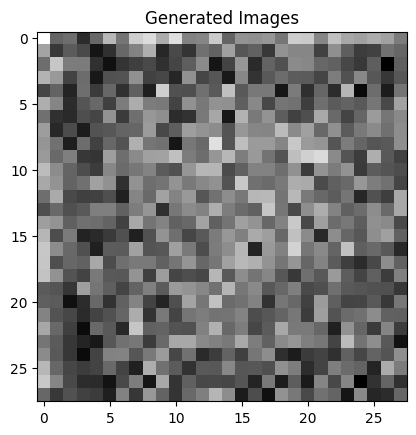

In [1]:
"""
Marcelo Gennari do Nascimento, 2022
marcelogennari@outlook.com

This script performs the sampling given the trained UNet model
"""
from tqdm import trange

import torch
from models import UNet
from diffusion_model import DiffusionProcess

import matplotlib.pyplot as plt
import torch.nn as nn

class DIP(nn.Module):
    def __init__(self):
        super(DIP, self).__init__()
        self.encoder = nn.Sequential(
            self.conv_block(1, 64)
        )
        self.decoder = nn.Sequential(
            self.conv_block(64, 1)
        )
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )
    
    def forward(self, x):
        #print(x.shape)
        x = self.encoder(x)
        #print(x.shape)
        x = self.decoder(x)
        #print(x.shape)
        return x

def display_image(tensor, title="Image"):
    image = tensor.squeeze(0).squeeze(0).cpu().detach().numpy()
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.show()


if __name__ == "__main__":
    # Prepare model
    device = "cuda"
    batch_size = 1
    prior = DIP().to(device)
    model = UNet().to(device)
    model.load_state_dict(torch.load("Model_DIP_DDPM_modified_schedule2.pth"))
    prior.load_state_dict(torch.load('DIP_sample.pth'))
    process = DiffusionProcess(variance_schedule=torch.linspace(1e-4, 0.01, steps=501))

    # Sampling
    
    xt = torch.randn((1,1,28,28))
    model.eval()
    prior.eval()
    with torch.no_grad():
        for t in trange(500,-1, -1):
            time = torch.ones(batch_size) * t
            et = model(xt.to(device), time.to(device))  # predict noise
            xt = process.inverse(xt.cpu(), et.cpu(), t)

    labels = ["Generated Images"] * 9

    for i in range(1):
        plt.tight_layout()
        plt.imshow(xt[i][0], cmap= "gray", interpolation= "none")
        plt.title(labels[i])
    plt.show()


In [2]:
from skimage.metrics import peak_signal_noise_ratio
from torchvision import datasets ,transforms
transform = transforms.Compose([
    transforms.ToTensor()
])
image , _ = datasets.MNIST(root='./data', train=True, download=True, transform=transform)[15]
image = image.reshape((1,1,28,28))
clean_image_np = image.squeeze().cpu().numpy()
refined_img_np = xt.squeeze().cpu().numpy()
print(image.shape)
print(xt.shape)
psnr_value = peak_signal_noise_ratio(clean_image_np, refined_img_np)
psnr_value

torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])


6.220640534638559